---
title: "[stock prediction] 2.1 주가 데이터셋 보조지표 추가"
author: "agsu"
date: "7/09/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock3.png
---

# 2. Data Preprocessing  
## 2.1. 주가 데이터셋 보조지표  추가  

이전 글 [[Stock Research] 1.2. 머신러닝 모델 비교](https://ag-su.github.io/blog/posts/02.model_selection.html)까지 주가 데이터셋 생성과 머신러닝 모델 비교를 통해 baseline model을 생성했다. 
이번 글 부터는 데이터 전처리를 진행한다. 모델을 이전 글에서 선택했던 baseline 모델로 fix하고, 데이터의 질을 높임으로써 성능을 향상시킨다. 그 첫번째로 주가데이터셋에 보조지표를 추가하여 설명변수의 크기를 늘린다.




### 목차 
- (1) 주식 데이터의 보조지표
- (2) 보조지표 추가   
- (3) 모델 학습 

<br>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import FinanceDataReader as fdr
import pymysql

import warnings
warnings.filterwarnings('ignore')
    
import ta

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## (1) 주식데이터의 보조지표 
주식데이터에서 보조지표란 기술적지표라고도 불리며, 다양한 각도와 계산식, 통계 등을 바탕으로 기본적 분석 방법들과 조합하여 보다 폭 넓은 시장 예측을 가능하게 도와주는 차트 분석 도구이다. 

[참고]  
-[01 보조지표란?](https://www.nanumtrading.com/fx-%eb%b0%b0%ec%9a%b0%ea%b8%b0/%ec%b0%a8%ed%8a%b8-%eb%b3%b4%ec%a1%b0%ec%a7%80%ed%91%9c-%ec%9d%b4%ed%95%b4/01-%eb%b3%b4%ec%a1%b0%ec%a7%80%ed%91%9c%eb%9e%80/)

그 중에서도, 주식 시장에서 많이 알려져 있고, 주가 예측에 자주 사용되는 보조지표로는 이동평균선을 예로 들어 확인해보겠다. 이동평균선을 캔들차트와 함께 시각화 하고, 각 종목과 날짜에 대해 어떻게 나타나는지 직접 확인한다. 

- **데이터 불러오기**  

`2018-01-01 ~ 2020-12-31` 기간 동안의 모든 데이터를 미리 저장해 놓은 주가 데이터셋을 불러온다. 

In [2]:
df_stock = pd.read_csv("stock_data_2018_2020.csv")
df_stock['Code'] = df_stock['Code'].apply(lambda x : str(x).zfill(6))
df_stock

,Code,Date,Open,High,Low,Close,Volume,Change
0,050120,2018-01-02,10250,12050,10150,11800,26086769,0.145631
1,050120,2018-01-03,11950,12450,10900,11750,20460474,-0.004237
2,050120,2018-01-04,11850,14150,11600,12600,60663854,0.072340
3,050120,2018-01-05,12800,13200,12000,12200,13935258,-0.031746
4,050120,2018-01-08,12450,13400,12350,12850,16471707,0.053279
...,...,...,...,...,...,...,...,...
1152013,000540,2020-12-23,2880,2945,2835,2870,87318,-0.010345
1152014,000540,2020-12-24,2850,2875,2845,2860,28350,-0.003484
1152015,000540,2020-12-28,2860,3000,2805,2820,66036,-0.013986
1152016,000540,2020-12-29,2820,2920,2705,2775,83187,-0.015957


- **이동평균선 캔들차트 시각화**  

In [3]:
IF = open('../data/code_list.txt')
lst_code = IF.readlines()

for idx, code in enumerate(lst_code):
    lst_code[idx] = code.strip()

In [4]:
@interact
def show_label_dist(code = lst_code):
    df = df_stock[df_stock['Code']==code]    
    ma_ls = [5, 20, 60, 120]
    for i in range(len(ma_ls)):
        sr1 = df['Close'].rolling(window=ma_ls[i]).mean()
        df['MA'+str(ma_ls[i])] = sr1
    df = df.dropna(axis=0)
    
    # 캔들 차트 
    candle = go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'], increasing_line_color= 'red', decreasing_line_color= 'blue')
    
    # 이동평균선
    line_ma5 = go.Scatter(x=df['Date'], y=df['MA5'], mode='lines', name='MA5', line=dict(color='magenta', width=0.5))
    line_ma20 = go.Scatter(x=df['Date'], y=df['MA20'], mode='lines', name='MA20', line=dict(color='blue', width=0.5))
    line_ma60 = go.Scatter(x=df['Date'], y=df['MA60'], mode='lines', name='MA60', line=dict(color='green', width=0.5))
    line_ma120 = go.Scatter(x=df['Date'], y=df['MA120'], mode='lines', name='MA120', line=dict(color='red', width=0.5))
    
    # 제목 추가
    layout = go.Layout(title='{} 캔들차트'.format(code), titlefont=dict(size=20, color='black'))
    
    fig = go.Figure(data=[candle, line_ma5, line_ma20, line_ma60, line_ma120], layout=layout)
    
    fig.show()

interactive(children=(Dropdown(description='code', options=('050120', '095340', '067290', '024120', '060720', …

위의 캔들차트에서 원하는 코드를 선택하여 4일, 20일, 60일, 120일 이동평균선을 확인할 수 있다.

<br>
<br>


## (2) 보조지표 추가

현재 baseline 모델에서는 10일치의 시가, 고가, 저가, 종가, 거래대금을 독립변수로 하여 학습을 진행하였다. 

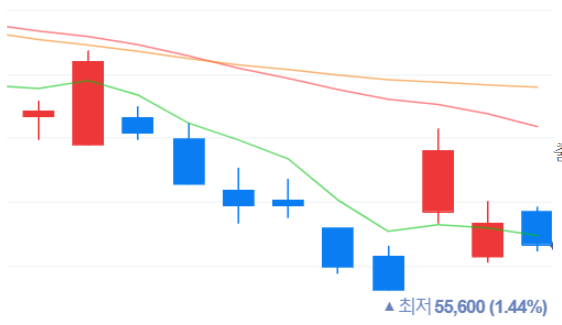출처-네이버 증권

하지만 10일간의 주가 차트 예시 사진을 보면, 너무 적은 정보만을 담고 있어 주가 예측을 위한 패턴을 찾아내기란 매우 어렵다. 따라서 주식의 여러 보조지표를 사용해서 해당 주식에 대한 압축된 정보를 독립변수에 추가해준다. 


앞서 시각화 해보았던 이동평균선 말고도 다양한 주식 보조지표들이 존재한다. 보조지표들을 모두 수동으로 계산하기에는 어려움이 있으므로 TA 라이브러리를 사용하여 총 49개의 보조지표를 추가한다. (+ trading_value) 

-[TA library github](https://github.com/mrjbq7/ta-lib)

- 보조지표 추가 코드 

In [5]:
df_index = pd.DataFrame()
for code, stock_df in tqdm(df_stock.groupby('Code')):
    
    # 이평선 생성
    ma = [5,20,60,120]
    for days in ma:
        stock_df['ma_'+str(days)] = stock_df['Close'].rolling(window = days).mean()
    
    # 여러 보조 지표 생성
    H, L, C, V = stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume']
    
    stock_df['trading_value'] = stock_df['Close']*stock_df['Volume']
    
    stock_df['MFI'] = ta.volume.money_flow_index(
        high=H, low=L, close=C, volume=V, fillna=True)
    
    stock_df['ADI'] = ta.volume.acc_dist_index(
        high=H, low=L, close=C, volume=V, fillna=True)
    
    stock_df['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
    stock_df['CMF'] = ta.volume.chaikin_money_flow(
        high=H, low=L, close=C, volume=V, fillna=True)
    
    stock_df['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
    stock_df['EOMEMV'] = ta.volume.ease_of_movement(
        high=H, low=L, volume=V, fillna=True)
    
    stock_df['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
    stock_df['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
    stock_df['VMAP'] = ta.volume.volume_weighted_average_price(
        high=H, low=L, close=C, volume=V, fillna=True)
    
    # Volatility
    stock_df['ATR'] = ta.volatility.average_true_range(
        high=H, low=L, close=C, fillna=True)
    stock_df['BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
    stock_df['BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
    stock_df['KCH'] = ta.volatility.keltner_channel_hband(
        high=H, low=L, close=C, fillna=True)
    stock_df['KCL'] = ta.volatility.keltner_channel_lband(
        high=H, low=L, close=C, fillna=True)
    stock_df['KCM'] = ta.volatility.keltner_channel_mband(
        high=H, low=L, close=C, fillna=True)
    stock_df['DCH'] = ta.volatility.donchian_channel_hband(
        high=H, low=L, close=C, fillna=True)
    stock_df['DCL'] = ta.volatility.donchian_channel_lband(
        high=H, low=L, close=C, fillna=True)
    stock_df['DCM'] = ta.volatility.donchian_channel_mband(
        high=H, low=L, close=C, fillna=True)
    stock_df['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)
    # Trend
    stock_df['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
    stock_df['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
    stock_df['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
    stock_df['MACD'] = ta.trend.macd(close=C, fillna=True)
    stock_df['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
    stock_df['VIneg'] = ta.trend.vortex_indicator_neg(
        high=H, low=L, close=C, fillna=True)
    stock_df['VIpos'] = ta.trend.vortex_indicator_pos(
        high=H, low=L, close=C, fillna=True)
    stock_df['TRIX'] = ta.trend.trix(close=C, fillna=True)
    stock_df['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
    stock_df['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
    stock_df['DPO'] = ta.trend.dpo(close=C, fillna=True)
    stock_df['KST'] = ta.trend.kst(close=C, fillna=True)
    stock_df['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
    stock_df['ParabolicSAR'] = ta.trend.psar_down(
        high=H, low=L, close=C, fillna=True)
    stock_df['STC'] = ta.trend.stc(close=C, fillna=True)
    # Momentum
    stock_df['RSI'] = ta.momentum.rsi(close=C, fillna=True)
    stock_df['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
    stock_df['TSI'] = ta.momentum.tsi(close=C, fillna=True)
    stock_df['UO'] = ta.momentum.ultimate_oscillator(
        high=H, low=L, close=C, fillna=True)
    stock_df['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
    stock_df['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
    stock_df['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
    stock_df['KAMA'] = ta.momentum.kama(close=C, fillna=True)
    stock_df['ROC'] = ta.momentum.roc(close=C, fillna=True)
    stock_df['PPO'] = ta.momentum.ppo(close=C, fillna=True)
    stock_df['PVO'] = ta.momentum.pvo(volume=V, fillna=True)
    
    df_index = df_index.append(stock_df) 

# 저장
df_index.to_csv("stock_data_2018_2020_add_index.csv", index=False)
df_index

100%|██████████████████████████████████████████| 1561/1561 [07:35<00:00,  3.42it/s]


,Code,Date,Open,High,Low,Close,Volume,Change,ma_5,ma_20,...,SRSI,TSI,UO,SR,WR,AO,KAMA,ROC,PPO,PVO
862985,000020,2018-01-02,9750,9900,9700,9870,120676,0.012308,NaN,NaN,...,0.000000,0.000000,0.000000,85.000000,-15.000000,0.000000,9870.000000,0.000000,0.000000,0.000000
862986,000020,2018-01-03,9900,10250,9820,10000,268220,0.013171,NaN,NaN,...,0.000000,100.000000,28.571429,54.545455,-45.454545,0.000000,9925.471999,0.000000,0.104967,8.943334
862987,000020,2018-01-04,10050,10050,9680,9750,161342,-0.025000,NaN,NaN,...,0.000000,95.815900,25.000000,12.280702,-87.719298,0.000000,9854.744908,0.000000,-0.015865,9.215678
862988,000020,2018-01-05,9750,9980,9750,9910,116604,0.016410,NaN,NaN,...,0.000000,92.627651,33.333333,40.350877,-59.649123,0.000000,9882.663078,0.000000,0.018877,6.837356
862989,000020,2018-01-08,10000,10150,9940,9950,158326,0.004036,9896.0,NaN,...,0.000000,90.156386,30.612245,47.368421,-52.631579,0.000000,9935.876263,0.000000,0.078152,7.233628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43418,950130,2020-12-22,23950,23950,22800,22900,978011,-0.043841,23490.0,22212.5,...,0.601825,-1.890990,29.641945,41.379310,-58.620690,577.058824,22725.390944,17.737789,-0.505568,-12.450728
43419,950130,2020-12-23,23000,23300,21000,21450,1239228,-0.063319,23080.0,22310.0,...,0.353271,-3.660151,28.338277,23.963134,-76.036866,353.382353,22679.784965,-15.049505,-1.064724,-16.358507
43420,950130,2020-12-24,21500,21800,19600,21700,857865,0.011655,22700.0,22382.5,...,0.083197,-4.812902,38.852203,20.792079,-79.207921,-58.235294,22583.248771,-12.323232,-1.408773,-20.829146
43421,950130,2020-12-28,21750,21800,19500,19650,1523257,-0.094470,21930.0,22322.5,...,0.000000,-7.972071,33.462925,1.470588,-98.529412,-402.647059,22055.737842,-13.245033,-2.394064,-22.448964


보조지표를 추가하여 8개였던 컬럼이 58개의 컬럼이 된 것을 확인하였다.

<br>
<br>

## (3) 모델 학습

- **데이터셋 생성 함수** 

위에서 보조지표를 추가 했던 방법과 동일하게 미리 생성해 놓은 보조지표 추가 데이터셋을 서버 DB에서 불러온다. baseline 모델에서 진행했던 데이터셋을 더 늘려 train 2017-2020, test 2021 기간 동안의 데이터를 사용한다. 

In [11]:
def make_dataset(train=True):
    
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
    
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        if train: 
            sql_query = '''
                        SELECT *
                        FROM stock_{}
                        WHERE Date BETWEEN '2017-01-01' AND '2020-12-31'
                        '''.format(code)
        else:
            sql_query = '''
                        SELECT *
                        FROM stock_{}
                        WHERE Date BETWEEN '2021-01-01' AND '2021-12-31'
                        '''.format(code)
        
        stock = pd.read_sql(sql = sql_query, con = db_dsml)   

        lst_stock = stock.values.tolist()


        for idx, row in enumerate(lst_stock): 
            date, trading_value = row[0].date().strftime("%Y%m%d"), row[4]*row[5]
            if trading_value >= 100000000000:
                if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                sub_stock = lst_stock[idx-9:idx+1] 

                # 10일간의 데이터 
                lst_result = []
                for row2 in sub_stock:
                    lst_prices, lst_index = row2[1:6], row2[8:]
                    lst_result += lst_prices + lst_index + [trading_value]

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return np.array(lst_X), np.array(lst_Y), np.array(lst_code_date)

- **train dataset 생성** 

In [14]:
trainX, trainY, lst_code_date = make_dataset(train=True)

100%|██████████████████████████████████████████| 1561/1561 [02:16<00:00, 11.44it/s]


- **test dataset 생성** 

In [15]:
testX, testY, lst_code_date_test = make_dataset(train=False)

100%|██████████████████████████████████████████| 1561/1561 [00:40<00:00, 38.37it/s]


- pickle 저장 

In [16]:
#collapse-hide
import pickle

dic_result = {
    'train': [trainX, trainY, lst_code_date],
    'test': [testX, testY, lst_code_date_test]
}

with open('dataset_2020_2021.pickle', 'wb') as handle:
    pickle.dump(dic_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

- pickle 불러오기 

In [17]:
#collapse-hide
with open('dataset_2020_2021.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [18]:
trainX, trainY, lst_code_date = dataset['train'][0], dataset['train'][1], dataset['train'][2]
testX, testY, lst_code_date_test = dataset['test'][0], dataset['test'][1], dataset['test'][2]

print('train dataset: ', trainX.shape, trainY.shape)
print('test dataset: ', testX.shape, testY.shape)

train dataset:  (13870, 550) (13870,)
test dataset:  (8341, 550) (8341,)


- **XGBoost 모델 학습**

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb.fit(trainX, trainY)

[17:26:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

- **모델 평가지표 시각화 함수**  
train, test 데이터셋에 대하여 Accuracy, AUC, f1_score, precision, recall 평가지표를 구하고, 시각화 한다. 

In [20]:
def plot_evauate(trainX, trainY, testX, testY, model):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    train_pred = model.predict(trainX)
    train_prob = model.predict_proba(trainX)[:, 1]
    
    test_pred = model.predict(testX) 
    test_prob = model.predict_proba(testX)[:, 1]
    
    
    # ROC Curve 시각화 
    fpr, tpr, thresholds = roc_curve(testY, test_prob) 
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    
    
    
    # 여러 평가지표 시각화 
    dic_name2func = { 'F1-score': f1_score, 
                     'Recall': recall_score, 
                     'Precision': precision_score, 
                     'Accuracy': accuracy_score, 
                     'ROCAUC': roc_auc_score }
    
    lst_result = []
    for name, func in dic_name2func.items():
        if name == 'ROCAUC':
            train = func(trainY, train_prob)
            test = func(testY, test_prob)
            
        else:
            train = func(trainY, train_pred)
            test = func(testY, test_pred)
        
        lst_result.append([name, train, test])
    
    df = pd.DataFrame(data=lst_result,
                columns=['name', 'train', 'test'])
    df = df.melt(id_vars='name')    
        
    ax = sns.barplot(data=df, x='name', y='value', hue='variable')
    ax.set_ylim(0, 1)
    
    # 텍스트 추가 
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, round(height, 3), ha = 'center', size = 10)

    plt.show()

- **성능 평가** 

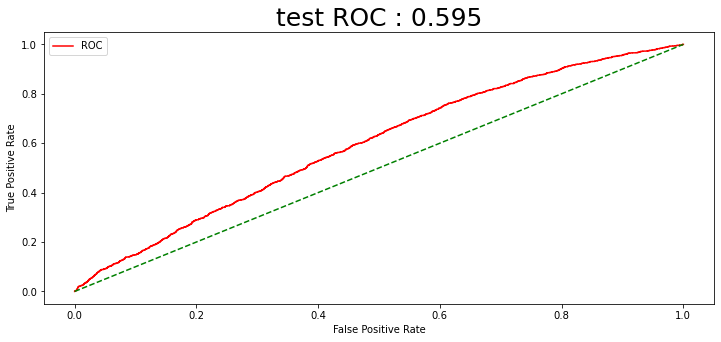

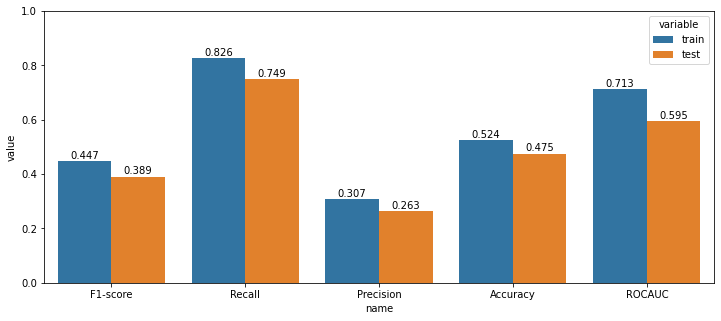

In [21]:
plot_evauate(trainX, trainY, testX, testY, xgb)

rocauc score는 0.595의 성능을 보였다. 데이터의 기간을 늘리고, 보조지표를 추가함으로써 지난 글의 Baseline Model의 0.56 보다 성능이 향상되었다.      
다음 글에서는 현재 사용하고 있는 통합 종목 주가 데이터셋의 종목별 가격이 모두 다른 점을 보완하기 위해 데이터를 표준화하는 시간을 가진다. 